<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/TimeSeriesAnalysis_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Workflow
This colab uses the labeled CA data for Multivariate time series forecasting called Vector Autoregression
(VAR).



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture


import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# Load Data

In [8]:
macrodata = sm.datasets.macrodata.load_pandas().data
data = macrodata.iloc[:, 2:4]
data.tail(2)
#macrodata.tail(2)

,realgdp,realcons
201,12901.504,9189.0
202,12990.341,9256.0


In [4]:
NY_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Sep26.csv',low_memory=False)
NY_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,305506.0,LessSpread,flat_growth,0.0,flat_growth,0.0
1,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,24913.0,LessSpread,flat_growth,0.0,flat_growth,0.0
2,2020-03-01,36021,Columbia County,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0,0.0,59461.0,LessSpread,flat_growth,0.0,flat_growth,0.0
3,2020-03-01,36095,Schoharie County,26.0,9.0,0.0,0.0,13.0,0.0,24.47,2.137,27,49.852047,0,0.0,0,0.0,30999.0,LessSpread,flat_growth,0.0,flat_growth,0.0
4,2020-03-01,36033,Franklin County,28.0,27.0,0.0,0.0,7.0,0.0,10.82,2.205,56,30.704920,0,0.0,0,0.0,50022.0,LessSpread,flat_growth,0.0,flat_growth,0.0


In [11]:
NY_labeled_data.columns

Index(['Date', 'fips_x', 'County Name', 'retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases', 'population', 'label', 'growth_label',
       'New Cases/1k population', 'growth_label_1k', 'growth_1k_pop'],
      dtype='object')

In [16]:
columns = ['retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent','New Cases/1k population']

NY_labeled_data_filter = NY_labeled_data.filter(columns, axis=1)

In [17]:
NY_labeled_data_filter.head(3)

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New Cases/1k population
0,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0.0
1,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0.0
2,21.0,4.0,0.0,25.0,4.0,0.0,19.75,5.337,58,93.682154,0,0.0,0.0


# Long Version

In [108]:
NY_labeled_data[NY_labeled_data['County Name']=='Suffolk County']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k,growth_1k_pop
5,2020-03-01,36103,Suffolk County,3.0,3.0,5.0,1.0,5.0,0.0,-9.23,5.112,58,1618.991283,0,0.000,0,0.000000,1476601.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
57,2020-03-02,36103,Suffolk County,3.0,5.0,31.0,0.0,4.0,-1.0,3.28,8.617,99,1618.991283,0,0.000,0,0.000000,1476601.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
159,2020-03-03,36103,Suffolk County,2.0,2.0,14.0,1.0,4.0,0.0,6.42,8.597,99,1618.991283,0,0.000,0,0.000000,1476601.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
197,2020-03-04,36103,Suffolk County,5.0,6.0,30.0,1.0,4.0,-1.0,9.03,8.672,100,1618.991283,0,0.000,0,0.000000,1476601.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
283,2020-03-05,36103,Suffolk County,4.0,6.0,37.0,3.0,4.0,-1.0,13.11,9.199,106,1618.991283,0,0.000,0,0.000000,1476601.0,LessSpread,flat_growth,0.000000,flat_growth,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,2020-08-17,36103,Suffolk County,0.0,0.0,0.0,0.0,-35.0,9.0,60.18,4.922,56,1618.991283,1,0.782,26,48.714286,1476601.0,LessSpread,mild_decrement,0.017608,mild_decrement,-0.002709
9594,2020-08-18,36103,Suffolk County,0.0,0.0,0.0,0.0,-33.0,9.0,67.00,5.684,65,1618.991283,1,0.782,50,48.857143,1476601.0,LessSpread,mild_decrement,0.033862,mild_growth,0.020724
9680,2020-08-19,36103,Suffolk County,0.0,0.0,0.0,0.0,-34.0,10.0,60.19,5.039,58,1618.991283,1,0.782,70,51.000000,1476601.0,LessSpread,mild_decrement,0.047406,mild_decrement,-0.011372
9694,2020-08-20,36103,Suffolk County,0.0,0.0,0.0,0.0,-33.0,8.0,78.14,6.373,73,1618.991283,1,0.782,48,52.285714,1476601.0,LessSpread,mild_decrement,0.032507,mild_growth,0.006529


In [156]:
columns = ['Date', 'fips_x','retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 
       'mask_rule_active', 'mask_wearing_percent','New Cases/1k population']

#NY_labeled_data_filter = NY_labeled_data.filter(columns, axis=1)
NY_labeled_data_filter = NY_labeled_data[NY_labeled_data['fips_x']==36103].filter(columns, axis=1)

In [129]:
NY_labeled_data_filter.shape

(172, 15)

In [130]:
NY_labeled_data_filter.isnull().sum()

Date                       0
fips_x                     0
retail and recreation      0
grocery and pharmacy       0
parks                      0
transit stations           0
workplaces                 0
residential                0
driving                    0
m50                        0
m50_index                  0
population_density         0
mask_rule_active           0
mask_wearing_percent       0
New Cases/1k population    0
dtype: int64

In [157]:
NY_labeled_data_filter.index

Int64Index([   5,   57,  159,  197,  283,  333,  354,  428,  490,  525,
            ...
            9248, 9298, 9353, 9443, 9504, 9527, 9594, 9680, 9694, 9802],
           dtype='int64', length=172)

In [158]:
NY_labeled_data_filter.describe()

,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
count,172.0,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.00000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,36103.0,-27.587209,-3.517442,117.627907,-41.232558,-33.116279,13.162791,15.70907,3.550680,40.441860,0.738372,0.577407,0.169603
std,0.0,19.195164,11.547752,103.301642,22.051601,17.760538,8.408239,43.90180,2.239877,25.852078,0.440804,0.344709,0.255361
min,36103.0,-73.000000,-44.000000,-47.000000,-77.000000,-75.000000,-1.000000,-62.37000,0.034000,0.000000,0.000000,0.000000,0.000000
25%,36103.0,-44.000000,-10.250000,20.250000,-61.000000,-45.000000,8.000000,-24.66500,1.624750,18.000000,0.000000,0.000000,0.031153
50%,36103.0,-26.500000,-0.500000,107.500000,-42.000000,-35.000000,12.000000,12.89500,3.653500,41.500000,1.000000,0.782000,0.047068
75%,36103.0,-11.750000,4.000000,198.000000,-32.500000,-26.000000,19.000000,56.70750,5.113250,58.000000,1.000000,0.782000,0.166430
max,36103.0,7.000000,29.000000,357.000000,6.000000,5.000000,31.000000,90.77000,9.199000,106.000000,1.000000,0.782000,1.215630


## Make Date Index

In [159]:
NY_labeled_data_filter.tail(2)

,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
9694,2020-08-20,36103,0.0,0.0,0.0,0.0,-33.0,8.0,78.14,6.373,73,1,0.782,0.032507
9802,2020-08-21,36103,0.0,0.0,0.0,0.0,-34.0,8.0,90.77,6.886,79,1,0.782,0.031830


In [160]:
NY_labeled_data_filter['Date_Time'] = pd.to_datetime(NY_labeled_data_filter['Date'])

In [161]:
NY_labeled_data_filter = NY_labeled_data_filter.set_index('Date_Time')

In [162]:
NY_labeled_data_filter.head(2)

,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,,,
2020-03-01,2020-03-01,36103,3.0,3.0,5.0,1.0,5.0,0.0,-9.23,5.112,58,0,0.0,0.0
2020-03-02,2020-03-02,36103,3.0,5.0,31.0,0.0,4.0,-1.0,3.28,8.617,99,0,0.0,0.0


In [163]:
NY_labeled_data_filter = NY_labeled_data_filter.drop(['Date','fips_x'], axis=1)
NY_labeled_data_filter.head(2)

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,
2020-03-01,3.0,3.0,5.0,1.0,5.0,0.0,-9.23,5.112,58,0,0.0,0.0
2020-03-02,3.0,5.0,31.0,0.0,4.0,-1.0,3.28,8.617,99,0,0.0,0.0


In [164]:
NY_labeled_data_filter

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,mask_rule_active,mask_wearing_percent,New Cases/1k population
Date_Time,,,,,,,,,,,,
2020-03-01,3.0,3.0,5.0,1.0,5.0,0.0,-9.23,5.112,58,0,0.000,0.000000
2020-03-02,3.0,5.0,31.0,0.0,4.0,-1.0,3.28,8.617,99,0,0.000,0.000000
2020-03-03,2.0,2.0,14.0,1.0,4.0,0.0,6.42,8.597,99,0,0.000,0.000000
2020-03-04,5.0,6.0,30.0,1.0,4.0,-1.0,9.03,8.672,100,0,0.000,0.000000
2020-03-05,4.0,6.0,37.0,3.0,4.0,-1.0,13.11,9.199,106,0,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,0.0,0.0,0.0,0.0,-35.0,9.0,60.18,4.922,56,1,0.782,0.017608
2020-08-18,0.0,0.0,0.0,0.0,-33.0,9.0,67.00,5.684,65,1,0.782,0.033862
2020-08-19,0.0,0.0,0.0,0.0,-34.0,10.0,60.19,5.039,58,1,0.782,0.047406


# Visualize

In [165]:
NY_labeled_data_filter.dtypes

retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
mask_rule_active             int64
mask_wearing_percent       float64
New Cases/1k population    float64
dtype: object

In [167]:
S1 = NY_labeled_data_filter['retail and recreation'].fillna(NY_labeled_data_filter['retail and recreation'].mean())
S2 = NY_labeled_data_filter['grocery and pharmacy'].mean()
S3 = NY_labeled_data_filter['parks'].fillna(NY_labeled_data_filter['parks'].mean())
S4 = NY_labeled_data_filter['transit stations'].fillna(NY_labeled_data_filter['transit stations'].mean())
S5 = NY_labeled_data_filter['workplaces'].fillna(NY_labeled_data_filter['workplaces'].mean())
S6 = NY_labeled_data_filter['residential'].fillna(NY_labeled_data_filter['residential'].mean())
S7 = NY_labeled_data_filter['driving'].fillna(NY_labeled_data_filter['driving'].mean())
S8 = NY_labeled_data_filter['m50'].fillna(NY_labeled_data_filter['m50'].mean())
S9 = NY_labeled_data_filter['m50_index'].fillna(NY_labeled_data_filter['m50_index'].mean())
S11 = NY_labeled_data_filter['mask_rule_active'].fillna(NY_labeled_data_filter['mask_rule_active'].mean())
S12 = NY_labeled_data_filter['mask_wearing_percent'].fillna(NY_labeled_data_filter['mask_wearing_percent'].mean())
S13 = NY_labeled_data_filter['New Cases/1k population'].fillna(NY_labeled_data_filter['New Cases/1k population'].mean())

Text(0.5, 1.0, 'driving')

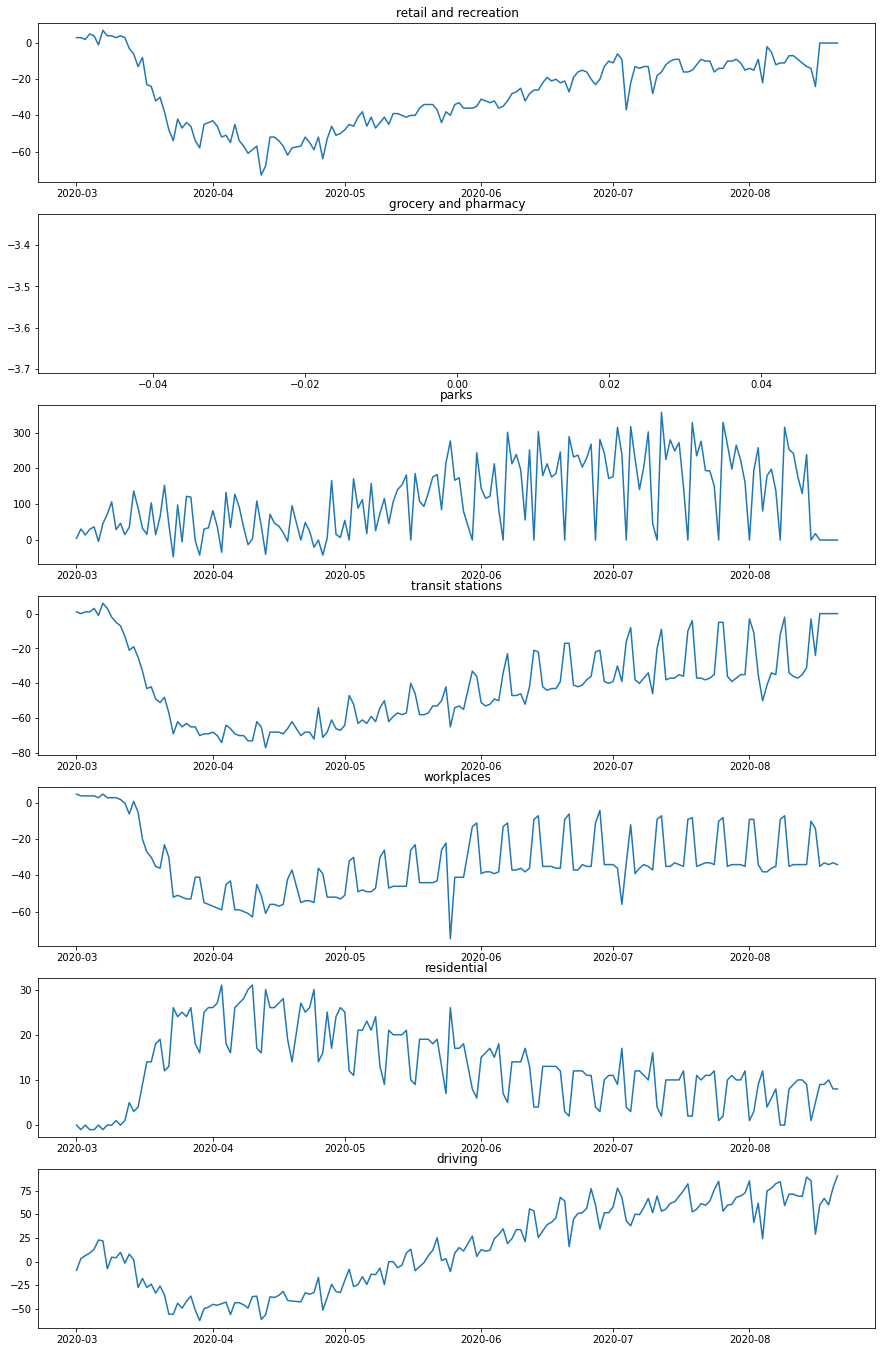

In [168]:
fig, axes = plt.subplots(7,1, figsize=(15,24))

axes[0].plot(S1)
axes[0].set_title ('retail and recreation')
axes[1].plot(S2)
axes[1].set_title ('grocery and pharmacy')
axes[2].plot(S3)
axes[2].set_title ('parks')
axes[3].plot(S4)
axes[3].set_title ('transit stations')
axes[4].plot(S5)
axes[4].set_title ('workplaces')
axes[5].plot(S6)
axes[5].set_title ('residential')
axes[6].plot(S7)
axes[6].set_title ('driving')


Text(0.5, 1.0, 'New Cases/1k population')

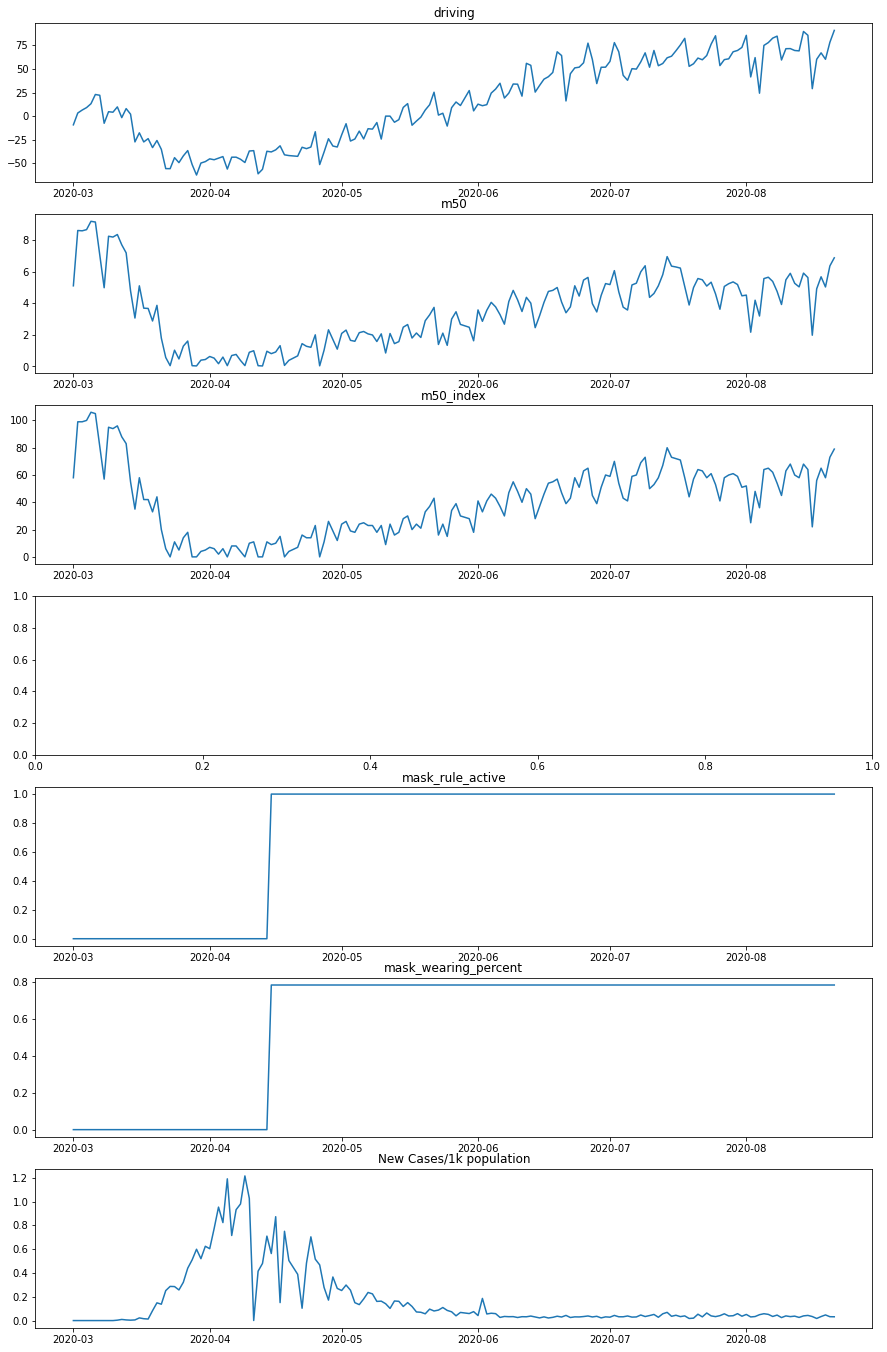

In [169]:
fig, axes = plt.subplots(7,1, figsize=(15,24))

axes[0].plot(S7)
axes[0].set_title ('driving')
axes[1].plot(S8)
axes[1].set_title ('m50')
axes[2].plot(S9)
axes[2].set_title ('m50_index')
#axes[3].plot(S10)
#axes[3].set_title ('population_density')
axes[4].plot(S11)
axes[4].set_title ('mask_rule_active')
axes[5].plot(S12)
axes[5].set_title ('mask_wearing_percent')
axes[6].plot(S13)
axes[6].set_title ('New Cases/1k population')

# Test for causality

In [60]:
#import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(NY_labeled_data_filter, maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1518  , p=0.0131  , df_denom=9788, df_num=1
ssr based chi2 test:   chi2=6.1612  , p=0.0131  , df=1
likelihood ratio test: chi2=6.1593  , p=0.0131  , df=1


ValueError: ignored

#Train-Validation Split

In [195]:
train = NY_labeled_data_filter[:int(0.8*(len(data)))]
print(train.shape)
valid = NY_labeled_data_filter[int(0.8*(len(data))):]
print(valid.shape)

(162, 12)
(10, 12)


In [171]:
nobs = 10
train = NY_labeled_data_filter[0:-nobs]
print(train.shape)
valid = NY_labeled_data_filter[-nobs:]
print(valid.shape)

(162, 12)
(10, 12)


#Stationarity

A stationary time series will more often than not give us a better set of predictions. Similar to the Augmented Dickey-Fuller test for univariate series, we have Johansen’s test for checking the stationarity of any multivariate time series data. Since the test works for only 12 variables, I have randomly dropped in the next iteration, I would drop another and check the eigenvalues.

coint_johansen()
statsmodels.tsa.vector_ar.vecm.coint_johansen(endog, det_order, k_ar_diff) - perform the Johansen cointegration test for determining the cointegration rank of a VECM.

endog - the data with presample.
det_order: int -
-1 - no deterministic terms.
0 - constant term.
1 - linear trend.
k_ar_diff: int, nonnegative - number of lagged differences in the model.

In [207]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
  dftest = adfuller(ts, autolag='AIC')
  adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
  for key,value in dftest[4].items():
    adf['Critical Value (%s)'%key] = value
  print (adf)
  p = adf['p-value']
  if p <= signif:
    print(f" Series is Stationary")
  else:
    print(f" Series is Non-Stationary")

In [212]:
#apply adf test on the series


for i in train.columns:
  print(i)
  #adf_test(train[[i]])
adf_test(train["retail and recreation"])

retail and recreation
grocery and pharmacy
parks
transit stations
workplaces
residential
driving
m50
m50_index
mask_rule_active
mask_wearing_percent
New Cases/1k population
Test Statistic           -2.097753
p-value                   0.245419
# Lags                    8.000000
# Observations          153.000000
Critical Value (1%)      -3.473830
Critical Value (5%)      -2.880623
Critical Value (10%)     -2.576945
dtype: float64
 Series is Non-Stationary


In [213]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [214]:
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0978
 No. Lags Chosen       = 8
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.2454. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "grocery and pharmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2403
 No. Lags Chosen       = 8
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.1919. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------


# Make data stationery

## 1st Differencing

In [215]:
# 1st difference
df_differenced = train.diff().dropna()

In [216]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1205
 No. Lags Chosen       = 7
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0251. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "grocery and pharmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.728
 No. Lags Chosen       = 6
 Critical value 1%     = -3.474
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

## 2nd Differencing

In [217]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [218]:

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail and recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1141
 No. Lags Chosen       = 8
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "grocery and pharmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2753
 No. Lags Chosen       = 8
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

#Vector Autoregression (VAR)

In [220]:
#removing constant columns
train = train.loc[:, (train != train.iloc[0]).any()]


valid = valid.loc[:, (valid != valid.iloc[0]).any()]

In [221]:
# Fit the model

model = VAR(endog=df_differenced)
model_fit = model.fit()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [241]:
## need to check why summary is giving error

#model_fit.summary()

LinAlgError: ignored

# Forecasting

In [239]:
# Make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))


/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


# Accuracy

In [153]:
NY_labeled_data_filter.dtypes

retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
population_density         float64
mask_rule_active             int64
mask_wearing_percent       float64
New Cases/1k population    float64
dtype: object

In [154]:
train.dtypes

retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
mask_rule_active             int64
mask_wearing_percent       float64
New Cases/1k population    float64
dtype: object

In [222]:
# Convert array to DataFrame
cols = valid.columns #NY_labeled_data_filter.columns
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])

for j in range(0, len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]
print(cols)

Index(['retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential', 'driving', 'm50',
       'm50_index', 'New Cases/1k population'],
      dtype='object')


## RMSE

In [223]:
# RMSE
import math
for i in cols:
    print(i)
    print('RMSE value for', i, 'is:', math.sqrt(mean_squared_error(pred[[i]], valid[[i]])))

retail and recreation
RMSE value for retail and recreation is: 10.995449504516161
grocery and pharmacy
RMSE value for grocery and pharmacy is: 4.548779669590626
parks
RMSE value for parks is: 106.67601047972185
transit stations
RMSE value for transit stations is: 18.972896147529497
workplaces
RMSE value for workplaces is: 30.449932428608896
residential
RMSE value for residential is: 8.342427142295334
driving
RMSE value for driving is: 72.43430390157306
m50
RMSE value for m50 is: 5.430773134555268
m50_index
RMSE value for m50_index is: 62.14040442319869
New Cases/1k population
RMSE value for New Cases/1k population is: 0.03658784211144099


# Final Prediction

In [235]:
# Make final predictions
model = VAR(endog=NY_labeled_data_filter)
model_fit = model.fit()



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [231]:
#model_fit.summary()

In [232]:
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[-8.11830762e+00 -8.98721555e+00  2.04143362e+01  5.15402756e+00
  -5.73431568e+00 -7.19832621e+00  7.88209185e+01  6.16463909e+00
   7.00773678e+01  9.95578747e-01  7.78542580e-01  1.57392627e-02]]


/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


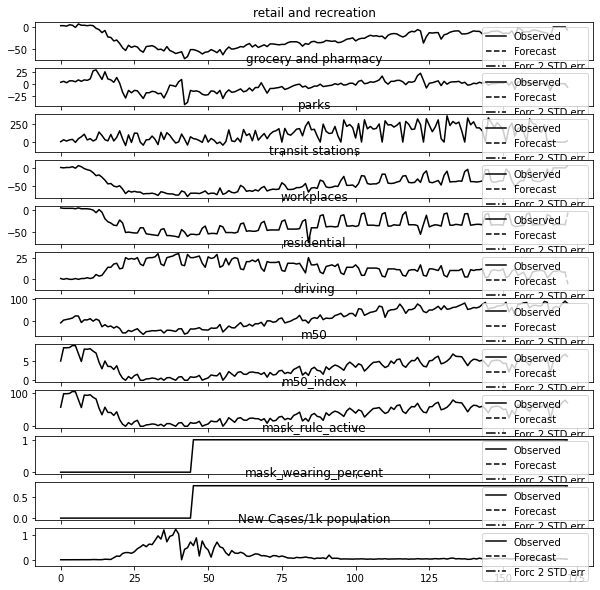

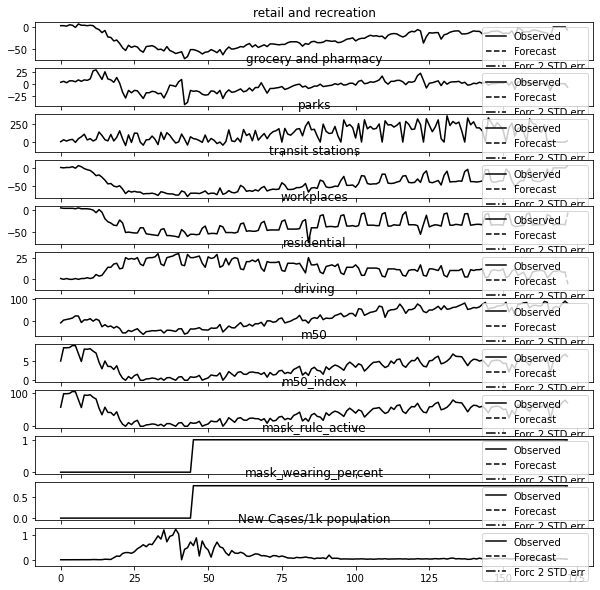

In [233]:
model_fit.plot_forecast(1)